### Solutions

#### Question 1

Alongside this notebook is a file `daily_quotes.csv` (the same one that we used for the Pandas exercises).

Using this data write a function that generates a composite of line charts (2 columns wide), that charts the closing price for each symbol in the data.

##### Solution

We'll re-use the code that we developed in the Pandas exercises to load the data:

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def load_df(file_name):
    df = pd.read_csv(
        'daily_quotes.csv',
        header=0,
        names=['symbol', 'date', 'close', 'volume', 'open', 'high', 'low'],
        index_col = 0,
        parse_dates=['date'],
    )
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]
    return df 

In [3]:
data = load_df('daily_quotes.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 508 entries, AAPL to MSFT
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    508 non-null    datetime64[ns]
 1   open    508 non-null    float64       
 2   high    508 non-null    float64       
 3   low     508 non-null    float64       
 4   close   508 non-null    float64       
 5   volume  508 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 27.8+ KB


We'll need to chart each symbol, but let's just deal with one for now and see how we'll create the chart.

First I'll set some default themes and chart sizes:

In [4]:
mpl.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [18, 10]

We'll extract the subset of data for `AAPL`:

In [5]:
subset = data.loc['AAPL', :]
subset

,date,open,high,low,close,volume
symbol,,,,,,
AAPL,2021-02-12,134.3500,135.5300,133.6921,135.3700,60145130
AAPL,2021-02-11,135.9000,136.3900,133.7700,135.1300,64280030
AAPL,2021-02-10,136.4800,136.9900,134.4000,135.3900,73046560
AAPL,2021-02-09,136.6200,137.8770,135.8500,136.0100,76774210
AAPL,2021-02-08,136.0300,136.9600,134.9200,136.9100,71297210
...,...,...,...,...,...,...
AAPL,2020-08-19,115.9833,117.1625,115.6100,115.7075,145538000
AAPL,2020-08-18,114.3525,116.0000,114.0075,115.5625,105633560
AAPL,2020-08-17,116.0625,116.0875,113.9625,114.6075,119561440


We'll use `date` for the x-axis, and `close` for the y-axis, and use a line chart:

Text(0.5, 1.0, 'AAPL')

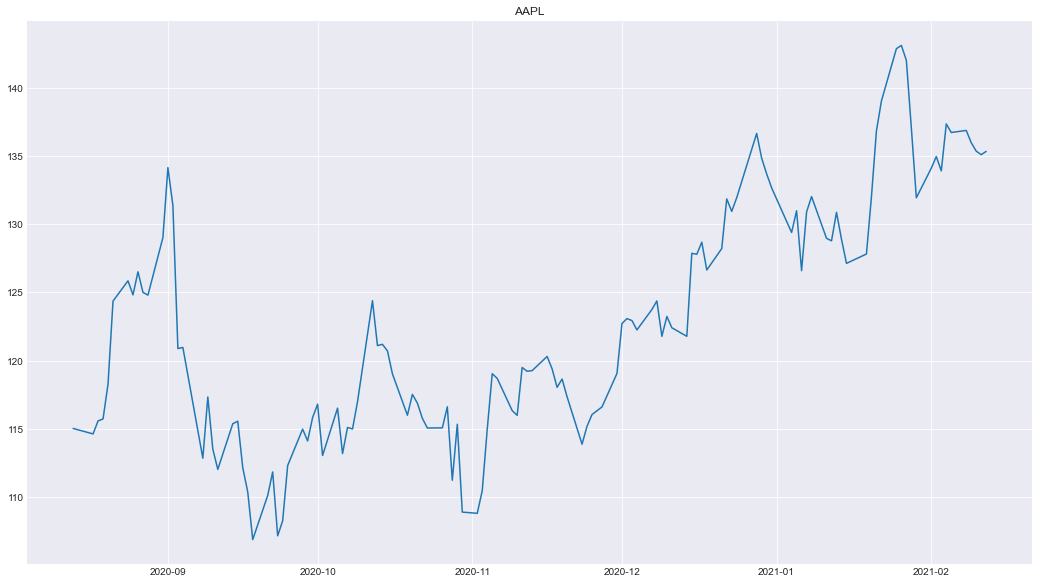

In [6]:
fig, ax = plt.subplots()
p = ax.plot(
    subset['date'].values,
    subset['close'].values,
    label='AAPL',
)
ax.set_title('AAPL')

Let's write a function to generate a chart given the dataset, a specific symbol, and the axes object we want to use for the chart.

In [7]:
def add_chart(data, symbol, ax):
    subset = data.loc[symbol, :]
    ax.plot(
        subset['date'].values,
        subset['close'].values,
        label=symbol
    )
    ax.set_title(symbol)

We can then use that function to create a plot given the axes we want to plot it on:

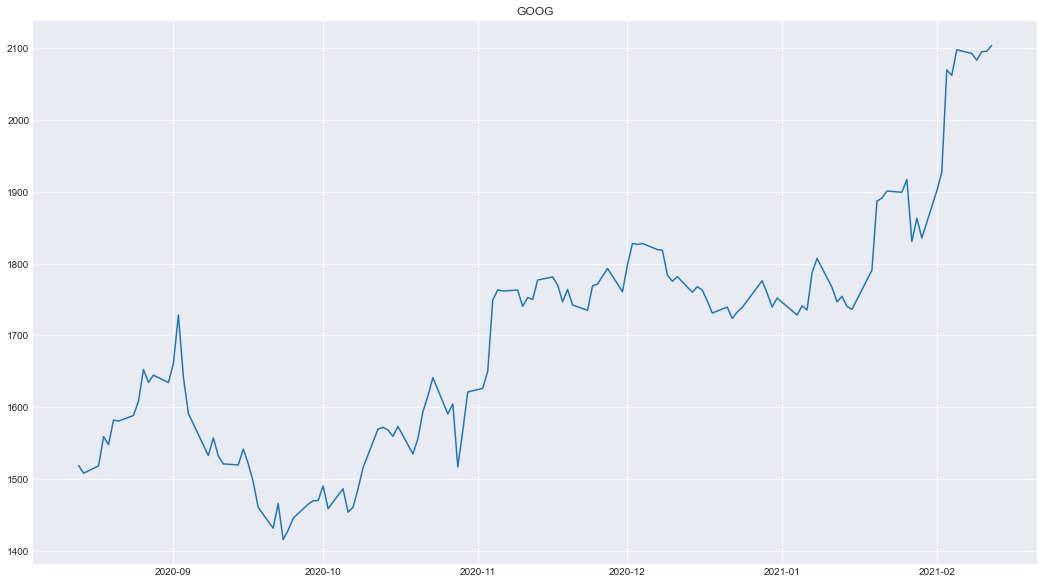

In [8]:
fig, ax = plt.subplots()
add_chart(data, 'GOOG', ax)

Now all we need to do is build up a multi-plot, 2 columns wide with as many rows as needed to accomodate all the symbols.

First we'll get the unique symbols in the data set:

In [9]:
symbols = set(data.index)
symbols

{'AAPL', 'AMZN', 'GOOG', 'MSFT'}

The number of columns is set to `2`, and the number of rows can be calculated (so it remains general no matter how many symbols are actually present in the data):

In [10]:
num_rows = len(symbols) // 2 + len(symbols) % 2
num_rows

2

We can now define the multiplot using those settings:

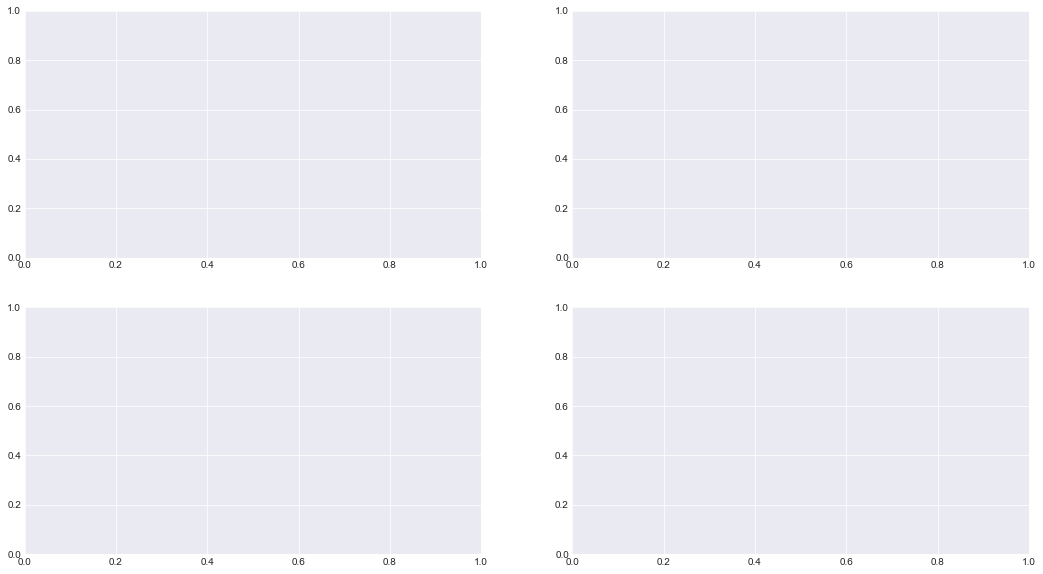

In [11]:
fig, axes = plt.subplots(num_rows, 2)

Remember that `axes` is a NumPy array shaped based on the rows and columns.

We're going to want to iterate through all the axes, so we'll reshape it so we can use a simple iteration:

In [12]:
axes

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [13]:
axes.reshape(axes.size)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

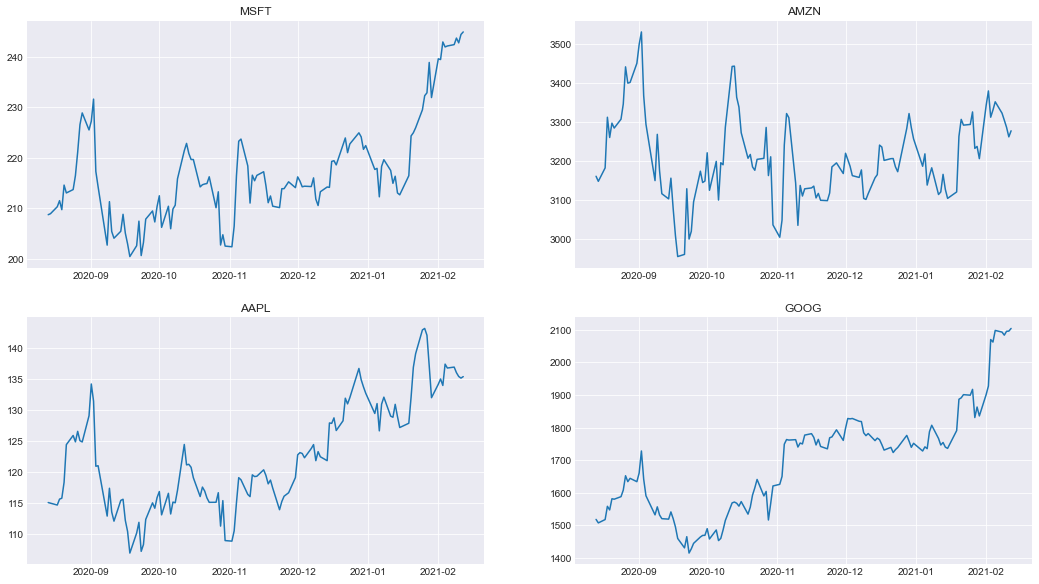

In [14]:
fig, axes = plt.subplots(num_rows, 2)

for ax, symbol in zip(axes.reshape(axes.size), symbols):
     add_chart(data, symbol, ax)

It would probably be nicer to present the charts based on an alphabeitcal sort of the symbols, so let's do that:

In [15]:
symbols = sorted(set(data.index))
symbols

['AAPL', 'AMZN', 'GOOG', 'MSFT']

Now, we can write a function that encapsulates all this, and let's even allow specifying the number fo columns we want to use for the charts:

In [16]:
def chart_symbols(data, num_cols=2):
    symbols = sorted(set(data.index))
    num_rows = len(symbols) // num_cols + len(symbols) % num_cols
    fig, axes = plt.subplots(num_rows, num_cols)
    for ax, symbol in zip(axes.reshape(axes.size), symbols):
        add_chart(data, symbol, ax)

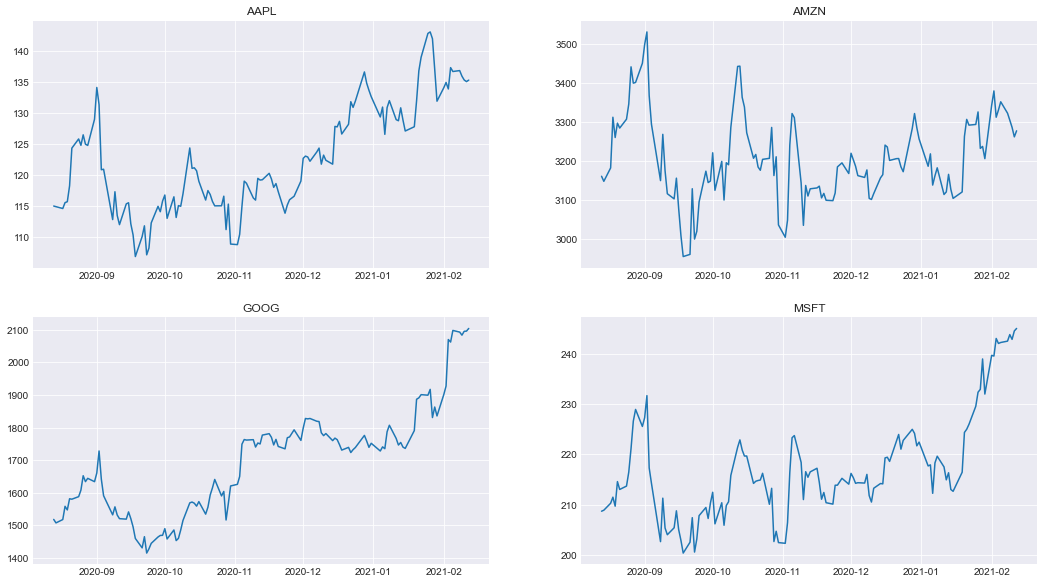

In [17]:
chart_symbols(data)

And we can change the number of columns as well:

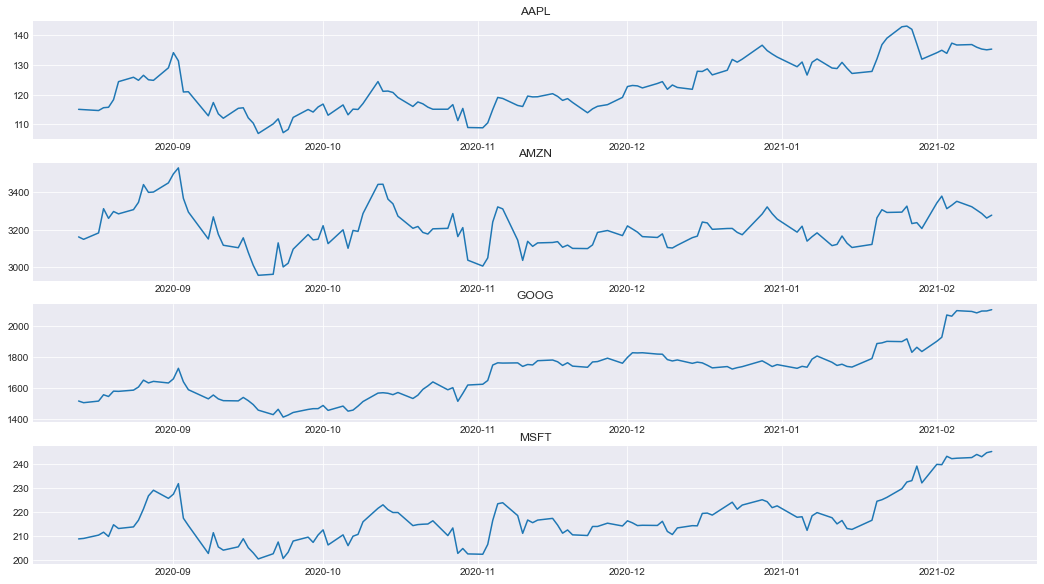

In [18]:
chart_symbols(data, 1)

### Question 2

Expand on your previous function to include an `n`-day moving average on each chart. (When you calculate the moving average, be careful with the order of the data in each subset of data).

##### Solution

Recall the function we wrote thta actually produces each individual chart:

In [19]:
def add_chart(data, symbol, ax):
    subset = data.loc[symbol, :]
    ax.plot(
        subset['date'].values,
        subset['close'].values,
        label=symbol
    )
    ax.set_title(symbol)

This is the function we'll need to modify to add the moving average to the axes.

To calculate an `n`-day moving average we'll use a windowing function. Let's try it out first, and then add it to the function later.

In [20]:
subset = data.loc['AAPL', :]

We have to be a bit careful here, because the data is not ordered in ascending date order:

In [21]:
subset

,date,open,high,low,close,volume
symbol,,,,,,
AAPL,2021-02-12,134.3500,135.5300,133.6921,135.3700,60145130
AAPL,2021-02-11,135.9000,136.3900,133.7700,135.1300,64280030
AAPL,2021-02-10,136.4800,136.9900,134.4000,135.3900,73046560
AAPL,2021-02-09,136.6200,137.8770,135.8500,136.0100,76774210
AAPL,2021-02-08,136.0300,136.9600,134.9200,136.9100,71297210
...,...,...,...,...,...,...
AAPL,2020-08-19,115.9833,117.1625,115.6100,115.7075,145538000
AAPL,2020-08-18,114.3525,116.0000,114.0075,115.5625,105633560
AAPL,2020-08-17,116.0625,116.0875,113.9625,114.6075,119561440


For our moving average we'll want to make sure the data is ordered correctly:

In [22]:
subset = subset.sort_values('date')
subset

,date,open,high,low,close,volume
symbol,,,,,,
AAPL,2020-08-13,114.4300,116.0425,113.9275,115.0100,210082080
AAPL,2020-08-14,114.8288,115.0000,113.0450,114.9075,165565200
AAPL,2020-08-17,116.0625,116.0875,113.9625,114.6075,119561440
AAPL,2020-08-18,114.3525,116.0000,114.0075,115.5625,105633560
AAPL,2020-08-19,115.9833,117.1625,115.6100,115.7075,145538000
...,...,...,...,...,...,...
AAPL,2021-02-08,136.0300,136.9600,134.9200,136.9100,71297210
AAPL,2021-02-09,136.6200,137.8770,135.8500,136.0100,76774210
AAPL,2021-02-10,136.4800,136.9900,134.4000,135.3900,73046560


And then we can calculate moving average - for example a 5 day moving average:

In [23]:
subset.rolling(window=5).mean()

,open,high,low,close,volume
symbol,,,,,
AAPL,NaN,NaN,NaN,NaN,NaN
AAPL,NaN,NaN,NaN,NaN,NaN
AAPL,NaN,NaN,NaN,NaN,NaN
AAPL,NaN,NaN,NaN,NaN,NaN
AAPL,115.13142,116.0585,114.11050,115.159,149276056.0
...,...,...,...,...,...
AAPL,136.23400,136.7720,134.71800,135.998,80872082.0
AAPL,136.41200,137.0854,134.96600,136.202,79565850.0
AAPL,136.55600,137.3294,135.12400,136.492,76198974.0


But this was a little wasteful - we calculated the moving average for every column - instead we should do it just for the `close` column:

In [24]:
subset['close'].rolling(window=5).mean()

symbol
AAPL        NaN
AAPL        NaN
AAPL        NaN
AAPL        NaN
AAPL    115.159
         ...   
AAPL    135.998
AAPL    136.202
AAPL    136.492
AAPL    136.040
AAPL    135.762
Name: close, Length: 127, dtype: float64

So now we can add this to our chart function, and now that we have two lines on the same plot we'll add the legend as well:

In [25]:
def add_chart(data, symbol, ax, mavg_window_n):
    subset = data.loc[symbol, :].sort_values('date')
    ma = subset['close'].rolling(window=mavg_window_n).mean()
    ax.plot(
        subset['date'].values,
        subset['close'].values,
        label='close'
    )
    ax.plot(
        subset['date'].values,
        ma,
        label=f'MA-{mavg_window_n}'
    )
    ax.set_title(symbol)
    ax.legend()

Let's try our new function out using our previously created multi-plot function. We'll need to modify it first to pass the moving average window.

In [26]:
def chart_symbols(data, mavg_window_n=5, num_cols=2):
    symbols = sorted(set(data.index))
    num_rows = len(symbols) // num_cols + len(symbols) % num_cols
    fig, axes = plt.subplots(num_rows, num_cols)
    for ax, symbol in zip(axes.reshape(axes.size), symbols):
        add_chart(data, symbol, ax, mavg_window_n)

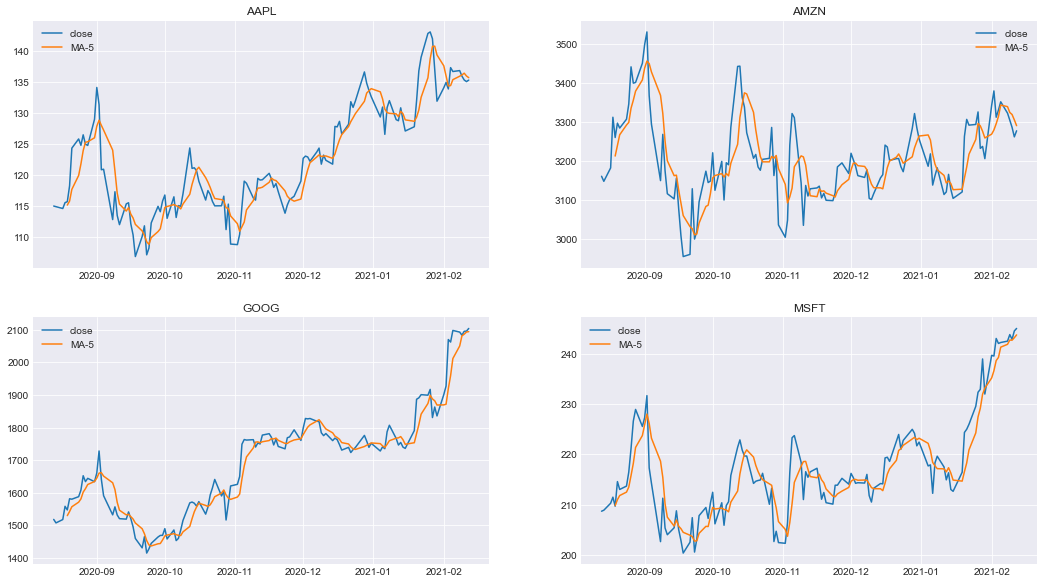

In [27]:
chart_symbols(data)

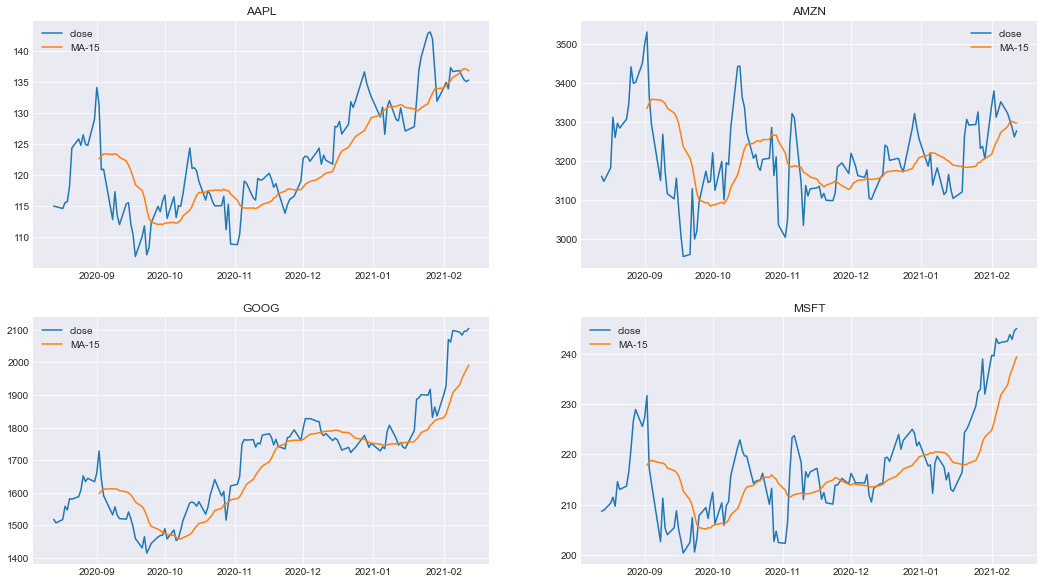

In [28]:
chart_symbols(data, 15)

#### Question 3

Using the previous charts, add horizontal lines for the 25th, 50th and 75th percentiles of the close price (calculated over the entire time period).

##### Solution

First, let's write a function that calculates the n-th percentile from a `subset` based on the `close` column, using the `quantile` method:

In [29]:
def close_percentile(subset, n):
    return subset['close'].quantile(n)

In [30]:
close_percentile(data.loc['AAPL', :], .5)

120.96

Now all we need to do is calculate those percentiles and add them to each chart:

In [31]:
def add_chart(data, symbol, ax, mavg_window_n):
    subset = data.loc[symbol, :].sort_values('date')
    ma = subset['close'].rolling(window=mavg_window_n).mean()
    ax.plot(
        subset['date'].values,
        subset['close'].values,
        label='close'
    )
    ax.plot(
        subset['date'].values,
        ma,
        label=f'MA-{mavg_window_n}'
    )
    ax.axhline(close_percentile(subset, .25), linestyle=':', color='green', label='25%')
    ax.axhline(close_percentile(subset, .75), linestyle=':', color='green', label='75%')
    ax.axhline(close_percentile(subset, .5), linestyle='--', color='blue', label='25%')
    ax.set_title(symbol)
    ax.legend()

And now we can re create our charts:

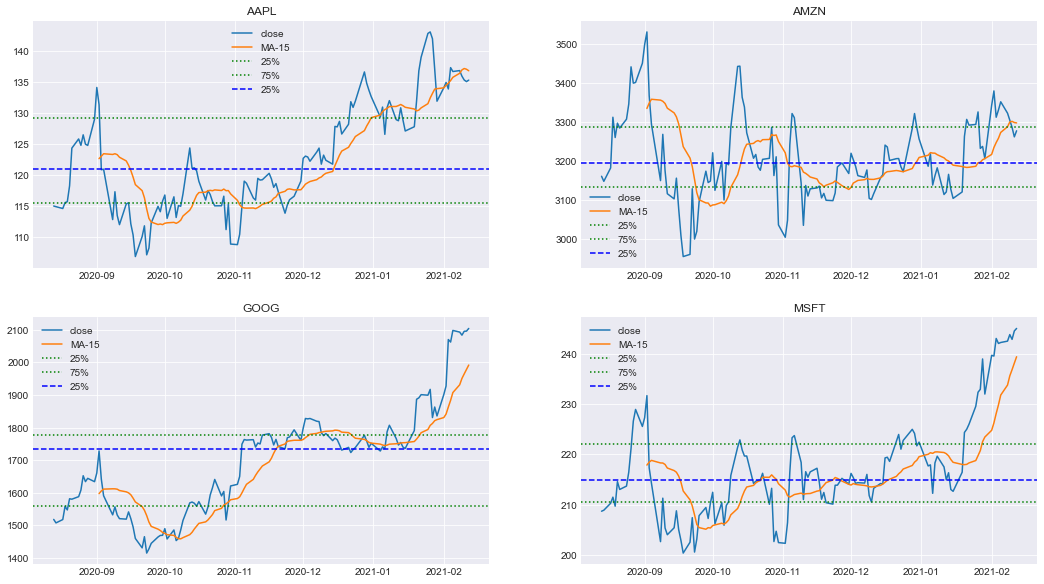

In [32]:
chart_symbols(data, mavg_window_n=15, num_cols=2)